In [27]:
import os
import glob 
import pickle

import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from scipy.stats import entropy
from sklearn.model_selection import KFold
from itertools import combinations
from sklearn.metrics import mutual_info_score, confusion_matrix

In [3]:
plt.rcParams['pdf.fonttype']=42

## Loss by Epoch

In [4]:
res_files = glob.glob("4head_results/res_bal_epoch_*")
epoch_df = []
for i, f in enumerate(res_files): 
    df = pd.read_csv(f, index_col=0)
    df['rep'] = i
    df['epoch'] = df.index
    epoch_df.append(df)
epoch_df = pd.concat(epoch_df)

In [5]:
epoch_df

,train_acc,train_loss,test_acc,test_loss,rep,epoch
0,0.459581,1.080961,0.558209,0.862388,0,0
1,0.538922,0.909446,0.620896,0.832125,0,1
2,0.583832,0.860663,0.567164,0.916643,0,2
3,0.582335,0.877880,0.623881,0.839854,0,3
4,0.593563,0.830239,0.558209,0.813511,0,4
...,...,...,...,...,...,...
45,0.735228,0.590805,0.637725,0.772646,4,45
46,0.730740,0.593894,0.619760,0.774853,4,46
47,0.745699,0.586790,0.613772,0.776892,4,47
48,0.734480,0.587259,0.616766,0.802110,4,48


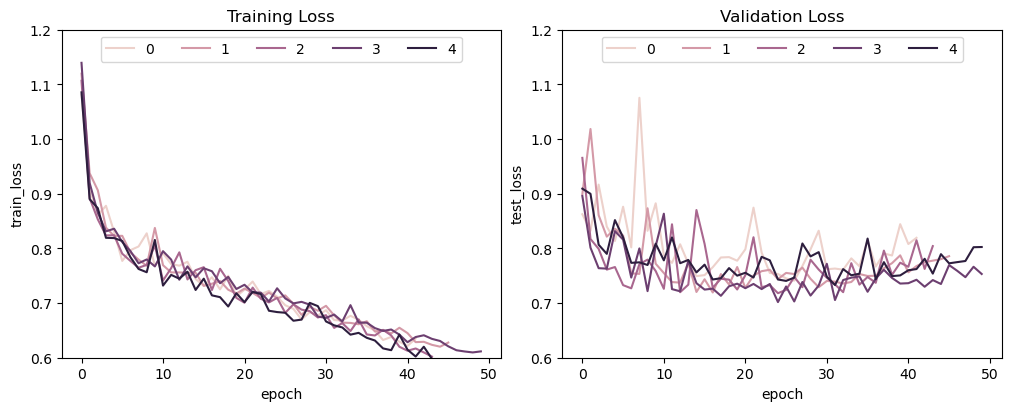

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout = True)

sns.lineplot(epoch_df, x='epoch', y = 'train_loss', hue='rep', ax=ax[0])
sns.lineplot(epoch_df, x='epoch', y = 'test_loss', hue='rep', ax=ax[1])

ax[0].set_title("Training Loss")
ax[0].legend(loc='upper center', ncol=5)
ax[0].set_ylim((0.6, 1.2))

ax[1].set_title("Validation Loss")
ax[1].legend(loc='upper center', ncol=5)
ax[1].set_ylim((0.6, 1.2))

plt.show()

In [7]:
res_files = glob.glob("4head_results/res_bal_elem_*")
no_comb_preds = []
for i, f in enumerate(res_files): 
    df = pd.read_csv(f, index_col=0)
    no_comb_preds.append(df['preds'].values)

res_files = glob.glob("4head_results/2_res_bal_elem_*")
comb_preds = []
for i, f in enumerate(res_files): 
    df = pd.read_csv(f, index_col=0)
    comb_preds.append(df['preds'].values)

In [8]:
print("no ReLU")
for i in no_comb_preds:
    print(np.unique(i, return_counts=True))

print("w/ ReLU")
for i in comb_preds:
    print(np.unique(i, return_counts=True))

no ReLU
(array([0, 1, 2]), array([ 99, 120, 115]))
(array([0, 1, 2]), array([110, 115, 109]))
(array([0, 1, 2]), array([147,  91,  96]))
(array([0, 1, 2]), array([128,  82, 124]))
(array([0, 1, 2]), array([121, 126,  88]))
w/ ReLU
(array([0, 1, 2]), array([120, 110, 104]))
(array([0, 1, 2]), array([130, 119,  85]))
(array([0, 1, 2]), array([152,  83, 100]))
(array([0, 1, 2]), array([124,  97, 113]))
(array([0, 1, 2]), array([103, 108, 123]))


In [9]:
MI = []
for a, b in combinations(comb_preds, r=2): 
    min_len = min(len(a), len(b))
    a = a[:min_len]
    b = b[:min_len]
    MI.append(mutual_info_score(a, b))

no_MI = []
for a, b in combinations(no_comb_preds, r=2): 
    min_len = min(len(a), len(b))
    a = a[:min_len]
    b = b[:min_len]
    no_MI.append(mutual_info_score(a, b))

In [10]:
# df_MI = pd.DataFrame([MI, no_MI], index = ['w/ ReLU', 'no ReLU']).T
# df_MI = df_MI.melt()

df_MI = pd.DataFrame([MI], index = ['w/ ReLU']).T
df_MI = df_MI.melt()

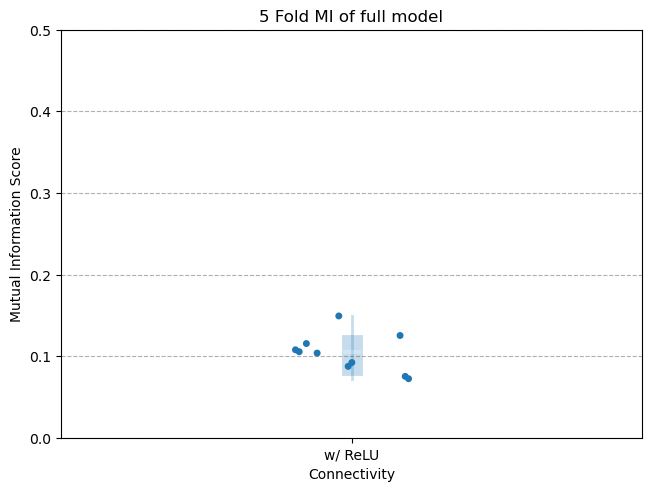

In [11]:
fig, ax = plt.subplots(constrained_layout=True)
sns.stripplot(df_MI, x = 'variable', y='value', hue='variable',  ax=ax)
sns.violinplot(df_MI, x = 'variable', y='value', hue='variable', 
               fill = False, linewidth=0, inner_kws=dict(box_width=15, whis_width=2, alpha=.25), ax=ax)
# ax.legend(loc="upper left", bbox_to_anchor=[1, 0, 0, 1])
ax.set_ylim((0.0, 0.5))
ax.set_title("5 Fold MI of full model")
ax.set_xlabel("Connectivity")
ax.set_ylabel("Mutual Information Score")
ax.grid(axis='y', linestyle='--')
plt.show()

## Accuracy vs. Epoch

In [13]:
res_files = glob.glob("4head_results/2_res_bal_elem_*")
acc = []
for i, f in enumerate(res_files): 
    df = pd.read_csv(f, index_col=0)
    fin_acc = (df['preds'] == df['labels']).sum() / df.shape[0]
    acc.append(fin_acc)

res_files = glob.glob("4head_results/res_bal_elem_*")
no_acc = []
for i, f in enumerate(res_files): 
    df = pd.read_csv(f, index_col=0)
    fin_acc = (df['preds'] == df['labels']).sum() / df.shape[0]
    no_acc.append(fin_acc)

In [14]:
df_acc = pd.DataFrame([acc, no_acc], index = ['w/ ReLU', 'no ReLU']).T
df_acc = df_acc.melt()

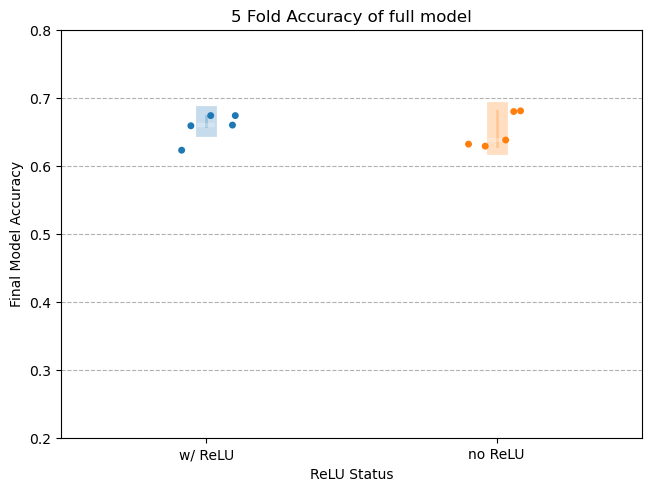

In [15]:
fig, ax = plt.subplots(constrained_layout=True)
sns.stripplot(df_acc, x = 'variable', y='value', hue='variable',  ax=ax)
sns.violinplot(df_acc, x = 'variable', y='value', hue='variable', 
               fill = False, linewidth=0, inner_kws=dict(box_width=15, whis_width=2, alpha=.25), ax=ax)
# ax.legend(loc="upper left", bbox_to_anchor=[1, 0, 0, 1])
ax.set_ylim((0.2, 0.8))
ax.set_title("5 Fold Accuracy of full model")
ax.set_xlabel("ReLU Status")
ax.set_ylabel("Final Model Accuracy")
ax.grid(axis='y', linestyle='--')
plt.show()

## Confusion matrix

In [16]:
res_files = glob.glob("4head_results/2_res_bal_elem_*")
elem_df = []
for i, f in enumerate(res_files): 
    df = pd.read_csv(f, index_col=0)
    df['rep'] = i
    elem_df.append(df)
elem_df = pd.concat(elem_df)

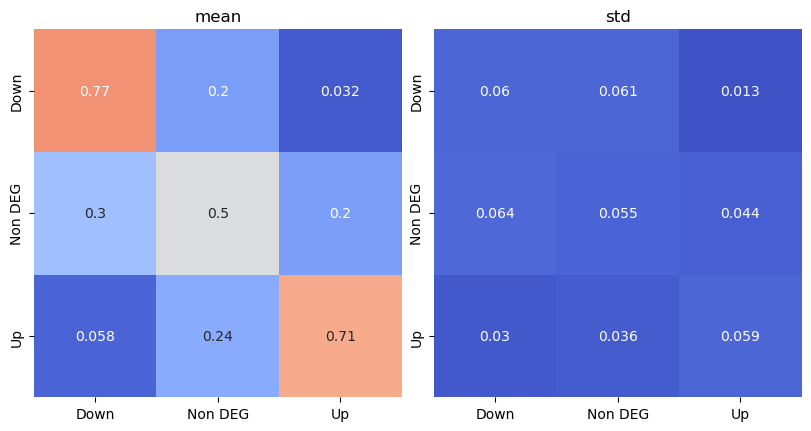

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(8 ,6), constrained_layout=True)
    
ccf_list = []
for i in range(5): 
    ccf_list.append(confusion_matrix(elem_df[elem_df['rep'] == i]['labels'], elem_df[elem_df['rep'] == i]['preds'], normalize='true'))
ccf_m = np.asarray(ccf_list).mean(axis=0)
ccf_s = np.asarray(ccf_list).std(axis=0)

sns.heatmap(ccf_m, vmin=0, vmax=1, xticklabels = ['Down', 'Non DEG', 'Up'], yticklabels = ['Down', 'Non DEG', 'Up'], 
            square=True, cmap='coolwarm', annot=True, cbar = False, ax=axes[0])
sns.heatmap(ccf_s, vmin=0, vmax=1, xticklabels = ['Down', 'Non DEG', 'Up'], yticklabels = ['Down', 'Non DEG', 'Up'], 
            square=True, cmap='coolwarm', annot=True, cbar = False, ax=axes[1])
# axes[0][j].imshow(ccf_m, vmin=0, vmax=1)
axes[0].set_title(f"mean")
# axes[1][j].imshow(ccf_s, vmin=0, vmax=1)
axes[1].set_title(f"std")
    


plt.show()

# Analyze Weights

## Model Functions

In [28]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [29]:
HIDDEN_DIM = 64
NUM_LAYERS = 4
NUM_HEADS = 8
DROPOUT = 0.1
LR = 0.001
OUTPUT_DIM = 3  # number of classes (-1, 0, 1)
NUM_EPOCHS = 50
BATCH_SIZE = 32

class FourHeadTransformerModel(nn.Module):
    def __init__(self, input_1_dim, input_2_dim, input_3_dim, input_4_dim, hidden_dim, output_dim, num_layers=2, num_heads=1, dropout=0.1):
        super(FourHeadTransformerModel, self).__init__()
        # For the tokens
        self.cls_1_embedding = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.cls_2_embedding = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.cls_3_embedding = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.cls_4_embedding = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.combined_cls_embedding = nn.Parameter(torch.randn(1, 1, hidden_dim))
        # embedding layer of the inputs
        self.input_1_embedding = nn.Linear(input_1_dim, hidden_dim)
        self.input_2_embedding = nn.Linear(input_2_dim, hidden_dim)
        self.input_3_embedding = nn.Linear(input_3_dim, hidden_dim)
        self.input_4_embedding = nn.Linear(input_4_dim, hidden_dim)

        # Transformer layers
        # TODO: may need to use tanh in attention instead of softmax
        encoder_layers = nn.TransformerEncoderLayer(hidden_dim, num_heads, dim_feedforward=hidden_dim*4, dropout=dropout, batch_first=True, norm_first=True)
        self.transformer_1 = nn.TransformerEncoder(encoder_layers, num_layers)
        self.transformer_2 = nn.TransformerEncoder(encoder_layers, num_layers)
        self.transformer_3 = nn.TransformerEncoder(encoder_layers, num_layers)
        self.transformer_4 = nn.TransformerEncoder(encoder_layers, num_layers)
        
        # Use self-attention mechanism to combine the outputs of the four heads
        self.linear = nn.Linear(hidden_dim * 4, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, _x1, _x2, _x3, _x4, x1_mask, x2_mask, x3_mask, x4_mask):
        _x1 = self.input_1_embedding(_x1)
        _x2 = self.input_2_embedding(_x2)
        _x3 = self.input_3_embedding(_x3)
        _x4 = self.input_4_embedding(_x4)

        # Add cls embedding, so that we can take the first output as the representation of the sequence
        _cls_1_embedding = self.cls_1_embedding.repeat(_x1.size(0), 1, 1)
        _cls_2_embedding = self.cls_2_embedding.repeat(_x2.size(0), 1, 1)
        _cls_3_embedding = self.cls_3_embedding.repeat(_x3.size(0), 1, 1)
        _cls_4_embedding = self.cls_4_embedding.repeat(_x4.size(0), 1, 1)

        _z1 = torch.cat((_cls_1_embedding, _x1), dim=1)
        _z2 = torch.cat((_cls_2_embedding, _x2), dim=1)
        _z3 = torch.cat((_cls_3_embedding, _x3), dim=1)
        _z4 = torch.cat((_cls_4_embedding, _x4), dim=1)
        
        _mask_1 = torch.cat((torch.ones(x1_mask.size(0), 1).to(device), x1_mask), dim=1)
        _mask_2 = torch.cat((torch.ones(x2_mask.size(0), 1).to(device), x2_mask), dim=1)
        _mask_3 = torch.cat((torch.ones(x3_mask.size(0), 1).to(device), x3_mask), dim=1)
        _mask_4 = torch.cat((torch.ones(x4_mask.size(0), 1).to(device), x4_mask), dim=1)
        
        _z1 = self.transformer_1(_z1, src_key_padding_mask=~_mask_1.bool())
        _z2 = self.transformer_2(_z2, src_key_padding_mask=~_mask_2.bool())
        _z3 = self.transformer_3(_z3, src_key_padding_mask=~_mask_3.bool())
        _z4 = self.transformer_3(_z4, src_key_padding_mask=~_mask_4.bool())
    
        
        # Pooling, we should not use average pooling since the sequence length is also important
        _z1 = _z1[:, 0, :]
        _z2 = _z2[:, 0, :]
        _z3 = _z3[:, 0, :]
        _z4 = _z4[:, 0, :]
        
        # Combine the output of three heads into a sequence
        _z = torch.concat((_z1, _z2, _z3, _z4), dim=1)
        _z = self.linear(_z)
        _z = _z.squeeze(-1) # (batch_size, hidden_dim, 1)
        _z = self.relu(_z)
        # Final classifier
        output = self.classifier(_z)
        return output

In [30]:
# Dataset Object
class FourGeneDataset(Dataset):
    def __init__(self, _data1, _data2, _data3, _data4, labels):
        self.data1 = _data1
        self.data2 = _data2
        self.data3 = _data3
        self.data4 = _data4
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        data1 = torch.FloatTensor(self.data1[idx]).to(device)
        data2 = torch.FloatTensor(self.data2[idx]).to(device)
        data3 = torch.FloatTensor(self.data3[idx]).to(device)
        data4 = torch.FloatTensor(self.data4[idx]).to(device)
        
        label = torch.LongTensor([self.labels[idx] + 1]).to(device)  # Add 1 to shift labels to 0, 1, 2
        
        mask1 = torch.ones(len(data1)).to(device)
        mask2 = torch.ones(len(data2)).to(device)
        mask3 = torch.ones(len(data3)).to(device)
        mask4 = torch.ones(len(data4)).to(device)
        
        return data1, data2, data3, data4, label, mask1, mask2, mask3, mask4

## handling the batches 
def comb_collate_fn(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    d1_sequences, d2_sequences, d3_sequences, d4_sequences, labels, d1_masks, d2_masks, d3_masks, d4_masks = zip(*batch)
    
    d1_lengths = [len(seq) for seq in d1_sequences]
    d2_lengths = [len(seq) for seq in d2_sequences]
    d3_lengths = [len(seq) for seq in d3_sequences]
    d4_lengths = [len(seq) for seq in d4_sequences]
    d1_max_len = max(d1_lengths)
    d2_max_len = max(d2_lengths)
    d3_max_len = max(d3_lengths)
    d4_max_len = max(d4_lengths)
    
    d1_padded_seqs = torch.zeros(len(d1_sequences), d1_max_len, d1_sequences[0].size(1))
    d2_padded_seqs = torch.zeros(len(d2_sequences), d2_max_len, d2_sequences[0].size(1))
    d3_padded_seqs = torch.zeros(len(d3_sequences), d3_max_len, d3_sequences[0].size(1))
    d4_padded_seqs = torch.zeros(len(d4_sequences), d4_max_len, d4_sequences[0].size(1))
    
    d1_padded_masks = torch.zeros(len(d1_sequences), d1_max_len)
    d2_padded_masks = torch.zeros(len(d2_sequences), d2_max_len)
    d3_padded_masks = torch.zeros(len(d3_sequences), d3_max_len)
    d4_padded_masks = torch.zeros(len(d4_sequences), d4_max_len)
    
    for i, (d1_seq, d2_seq, d3_seq, d4_seq, d1_length, d2_length, d3_length, d4_length) in enumerate(zip(d1_sequences, d2_sequences, d3_sequences, d4_sequences, d1_lengths, d2_lengths, d3_lengths, d4_lengths)):
        d1_padded_seqs[i, :d1_length] = d1_seq
        d2_padded_seqs[i, :d2_length] = d2_seq
        d3_padded_seqs[i, :d3_length] = d3_seq
        d4_padded_seqs[i, :d4_length] = d4_seq
        
        d1_padded_masks[i, :d1_length] = 1 
        d2_padded_masks[i, :d2_length] = 1 
        d3_padded_masks[i, :d3_length] = 1 
        d4_padded_masks[i, :d4_length] = 1 
        
    return d1_padded_seqs.to(device), d2_padded_seqs.to(device), d3_padded_seqs.to(device), d4_padded_seqs.to(device), torch.cat(labels), d1_padded_masks.to(device), d2_padded_masks.to(device), d3_padded_masks.to(device), d4_padded_masks.to(device)

## Analysis

In [31]:
model_files = glob.glob("4head_results/2_model_*.pt")
model_list = []
for r in model_files: 
    m = torch.load(r)
    model_list.append(m)

In [32]:
with torch.no_grad(): 
    lin_weights = m.linear.weight.cpu()
    lin_bias = m.linear.bias.cpu()
    lin_c_weights = m.classifier.weight.cpu()
    lin_c_bias = m.classifier.bias.cpu()

In [33]:
mult_res = torch.matmul(lin_c_weights, lin_weights)

In [38]:
mcg_weights = mult_res[:, :64]
atac_weights = mult_res[:, 64:128]
hic_weights = mult_res[:, 128:192]
gb_weights = mult_res[:, 192:256]
# mcg_weights.shape

In [50]:
print("mcg DMR DOWN DEG average weights: %.4f. std of weights: %.4f" % (mcg_weights.mean(axis=1)[0], mcg_weights.std(axis=1)[0]))
print("mcg DMR NON DEG average weights: %.4f. std of weights: %.4f" % (mcg_weights.mean(axis=1)[1], mcg_weights.std(axis=1)[1]))
print("mcg DMR UP DEG average weights: %.4f. std of weights: %.4f" % (mcg_weights.mean(axis=1)[2], mcg_weights.std(axis=1)[2]))
print()

print("atac DOWN DEG average weights: %.4f. std of weights: %.4f" % (atac_weights.mean(axis=1)[0], atac_weights.std(axis=1)[0]))
print("atac NON DEG average weights: %.4f. std of weights: %.4f" % (atac_weights.mean(axis=1)[1], atac_weights.std(axis=1)[1]))
print("atac UP DEG average weights: %.4f. std of weights: %.4f" % (atac_weights.mean(axis=1)[2], atac_weights.std(axis=1)[2]))
print()

print("hic DOWN DEG average weights: %.4f. std of weights: %.4f" % (hic_weights.mean(axis=1)[0], hic_weights.std(axis=1)[0]))
print("hic NON DEG average weights: %.4f. std of weights: %.4f" % (hic_weights.mean(axis=1)[1], hic_weights.std(axis=1)[1]))
print("hic UP DEG average weights: %.4f. std of weights: %.4f" % (hic_weights.mean(axis=1)[2], hic_weights.std(axis=1)[2]))
print()

print("genebody DOWN DEG average weights: %.4f. std of weights: %.4f" % (gb_weights.mean(axis=1)[0], gb_weights.std(axis=1)[0]))
print("genebody NON DEG average weights: %.4f. std of weights: %.4f" % (gb_weights.mean(axis=1)[1], gb_weights.std(axis=1)[1]))
print("genebody UP DEG average weights: %.4f. std of weights: %.4f" % (gb_weights.mean(axis=1)[2], gb_weights.std(axis=1)[2]))
print()

mcg DMR DOWN DEG average weights: 0.0014. std of weights: 0.0247
mcg DMR NON DEG average weights: 0.0036. std of weights: 0.0181
mcg DMR UP DEG average weights: 0.0036. std of weights: 0.0199

atac DOWN DEG average weights: 0.0001. std of weights: 0.0362
atac NON DEG average weights: -0.0021. std of weights: 0.0232
atac UP DEG average weights: 0.0004. std of weights: 0.0244

hic DOWN DEG average weights: 0.0017. std of weights: 0.0233
hic NON DEG average weights: -0.0029. std of weights: 0.0269
hic UP DEG average weights: -0.0012. std of weights: 0.0202

genebody DOWN DEG average weights: -0.0004. std of weights: 0.0268
genebody NON DEG average weights: -0.0004. std of weights: 0.0194
genebody UP DEG average weights: 0.0028. std of weights: 0.0243

